In [1]:
from pathlib import Path
from collections import Counter, defaultdict
from PIL import Image
import matplotlib.pyplot as plt

DATA_DIR = Path("data")
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR = DATA_DIR / "test"

def list_classes(root: Path):
    return sorted([d.name for d in root.iterdir() if d.is_dir()])

train_classes = list_classes(TRAIN_DIR)
test_classes = list_classes(TEST_DIR)

print("Klasy (train):", train_classes)
print("Klasy (test):", test_classes)

def count_images_per_class(root: Path):
    counts = {}
    for cls in list_classes(root):
        counts[cls] = sum(1 for _ in (root/cls).rglob("*.jpg"))
    return counts

train_counts = count_images_per_class(TRAIN_DIR)
test_counts = count_images_per_class(TEST_DIR)

print("\nLiczebności TRAIN:")
for k,v in train_counts.items():
    print(f"  {k:10s}: {v}")

print("\nLiczebności TEST:")
for k,v in test_counts.items():
    print(f"  {k:10s}: {v}")

Klasy (train): ['glioma', 'meningioma', 'notumor', 'pituitary']
Klasy (test): ['glioma', 'meningioma', 'notumor', 'pituitary']

Liczebności TRAIN:
  glioma    : 1321
  meningioma: 1339
  notumor   : 1595
  pituitary : 1457

Liczebności TEST:
  glioma    : 300
  meningioma: 306
  notumor   : 405
  pituitary : 300


In [2]:
def sample_sizes(root: Path, per_class=20):
    sizes = defaultdict(Counter)
    for cls in list_classes(root):
        files = list((root/cls).glob("*.jpg"))[:per_class]
        for fp in files:
            with Image.open(fp) as im:
                sizes[cls][im.size] += 1
    return sizes

sizes_train = sample_sizes(TRAIN_DIR, per_class=30)
print("Przykładowe rozmiary (train):")
for cls, cnt in sizes_train.items():
    print(f"{cls}: {dict(cnt)}")
    

Przykładowe rozmiary (train):
glioma: {(512, 512): 30}
meningioma: {(512, 512): 30}
notumor: {(350, 350): 2, (605, 613): 1, (562, 592): 1, (442, 442): 4, (630, 630): 11, (400, 442): 1, (220, 212): 1, (225, 225): 4, (254, 198): 1, (332, 442): 1, (206, 244): 1, (1024, 830): 1, (512, 512): 1}
pituitary: {(512, 512): 28, (474, 474): 1, (400, 400): 1}


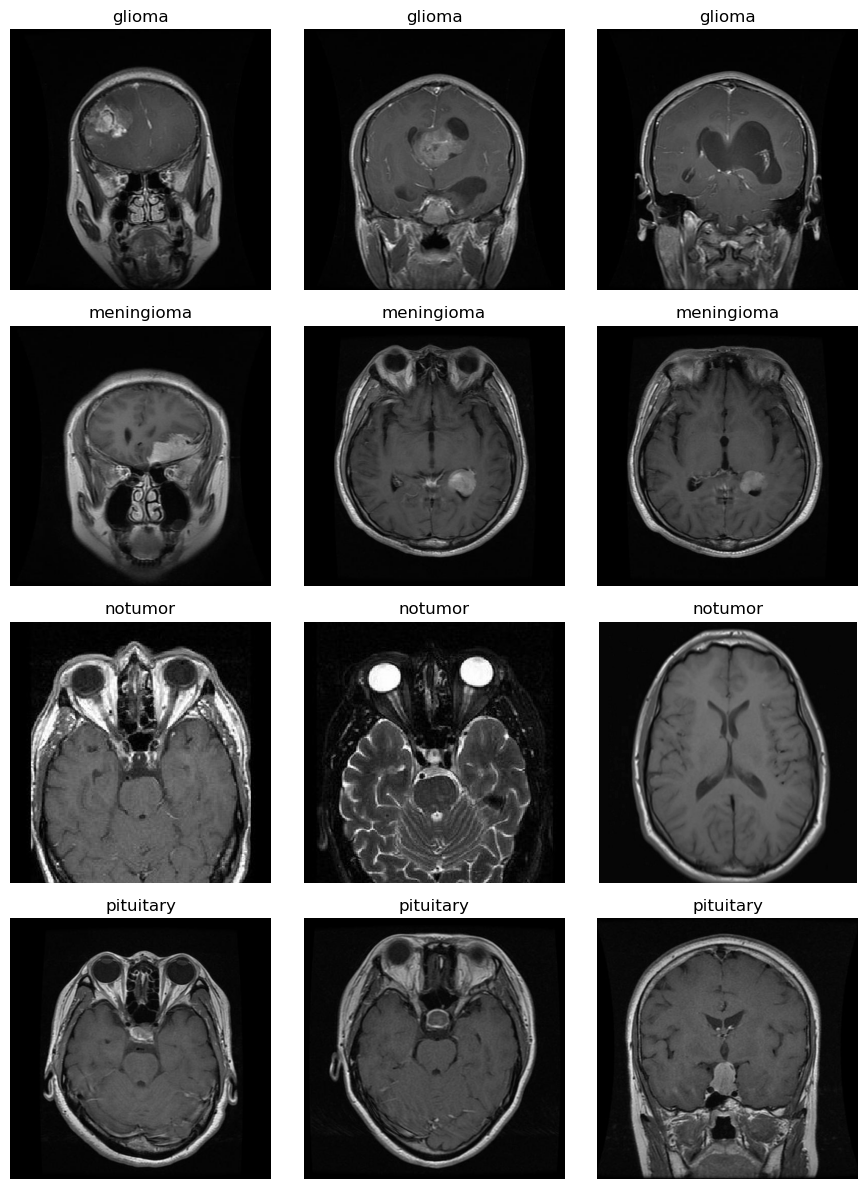

In [3]:
def show_grid(root: Path, cols=3):
    classes = list_classes(root)
    rows = len(classes)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    if rows == 1: axes = [axes]
    for r, cls in enumerate(classes):
        files = list((root/cls).glob("*.jpg"))[:cols]
        for c in range(cols):
            ax = axes[r][c] if rows > 1 else axes[c]
            if c < len(files):
                with Image.open(files[c]) as im:
                    ax.imshow(im, cmap="gray")
                    ax.set_title(cls)
            ax.axis("off")
    plt.tight_layout()
    plt.show()
    
show_grid(TRAIN_DIR, cols=3)

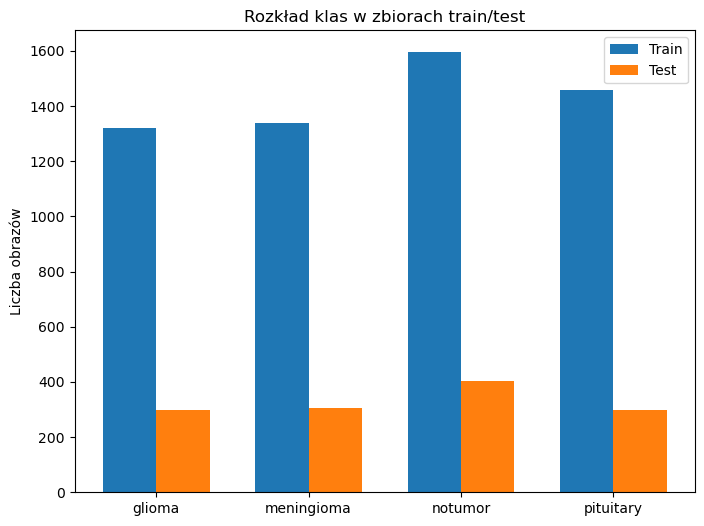

In [4]:
import matplotlib.pyplot as plt

train_counts = {"glioma":1321, "meningioma":1339, "notumor":1595, "pituitary":1457}
test_counts  = {"glioma":300, "meningioma":306, "notumor":405, "pituitary":300}

classes = list(train_counts.keys())
train_vals = [train_counts[c] for c in classes]
test_vals = [test_counts[c] for c in classes]

x = range(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(8,6))
ax.bar([i - width/2 for i in x], train_vals, width, label="Train")
ax.bar([i + width/2 for i in x], test_vals, width, label="Test")

ax.set_xticks(list(x))
ax.set_xticklabels(classes)
ax.set_ylabel("Liczba obrazów")
ax.set_title("Rozkład klas w zbiorach train/test")
ax.legend()
plt.show()

In [5]:
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [6]:
train_ds_full = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
val_base = datasets.ImageFolder(TRAIN_DIR, transform=eval_tfms)
test_ds = datasets.ImageFolder(TEST_DIR, transform=eval_tfms)

rng = np.random.default_rng(42)
targets = np.array([y for _, y in datasets.ImageFolder(TRAIN_DIR).imgs])

val_ratio = 0.15
train_idx, val_idx = [], []
for cls in np. unique(targets):
    cls_idx = np.where(targets == cls)[0]
    rng.shuffle(cls_idx)
    n_val = int(len(cls_idx)*val_ratio)
    val_idx.extend(cls_idx[:n_val].tolist())
    train_idx.extend(cls_idx[n_val:].tolist())
    
train_ds = Subset(train_ds_full, train_idx)
val_ds = Subset(val_base, val_idx)

len(train_ds), len(val_ds), len(test_ds)

(4857, 855, 1311)

In [7]:
BATCH_SIZE = 32

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

classes = datasets.ImageFolder(TRAIN_DIR).classes
print("Klasy: ", classes)

Klasy:  ['glioma', 'meningioma', 'notumor', 'pituitary']


In [8]:
xb, yb = next(iter(train_loader))
print("Batch shape: ", xb.shape)
print("Labels (pierwsze 10): ", yb[:10].tolist())
print("Przykładowe etykiety po nazwach: ", [classes[i] for i in yb[:10].tolist()])

Batch shape:  torch.Size([32, 3, 224, 224])
Labels (pierwsze 10):  [1, 1, 2, 0, 1, 0, 2, 0, 1, 2]
Przykładowe etykiety po nazwach:  ['meningioma', 'meningioma', 'notumor', 'glioma', 'meningioma', 'glioma', 'notumor', 'glioma', 'meningioma', 'notumor']


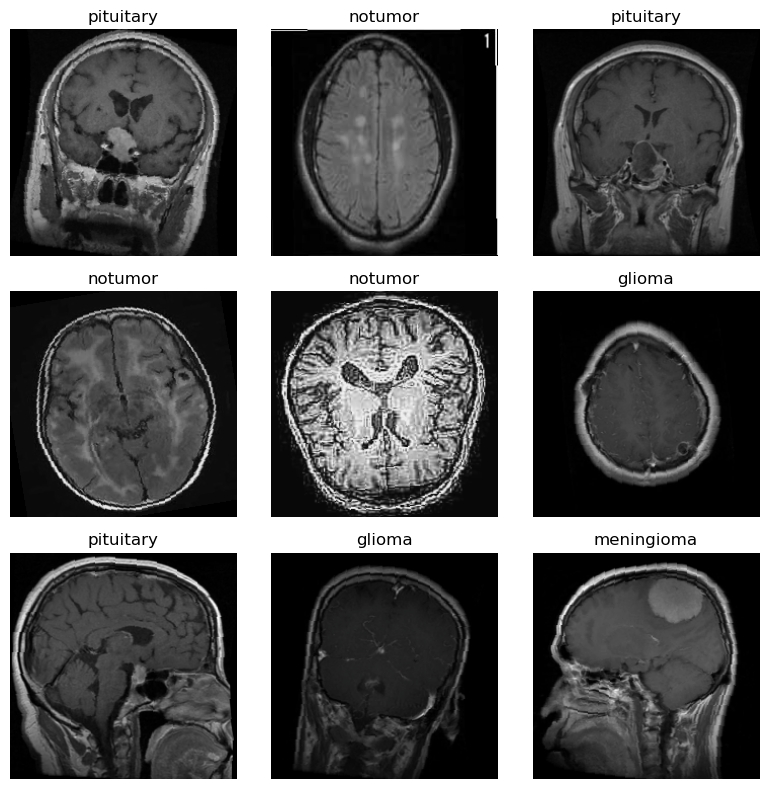

In [9]:
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denorm(x):
    return (x * IMAGENET_STD + IMAGENET_MEAN).clamp(0,1)

xb, yb = next(iter(train_loader))
plt.figure(figsize=(8,8))

for i in range(9):
    ax = plt.subplot(3,3,i+1)
    img = denorm(xb[i]).permute(1,2,0).numpy()
    ax.imshow(img)
    ax.set_title(classes[yb[i].item()])
    ax.axis("off")
plt.tight_layout()
plt.show()

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights

NUM_CLASSES = len(classes)

def build_model(num_classes=NUM_CLASSES, finetune=False):
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    
    for name, p in model.named_parameters():
        if not name.startswith("fc"):
            p.requires_grad = False
            
    if finetune:
        for name, p in model.named_parameters():
            if name.startswith("layer4") or name.startswith("fc"):
                p.requires_grad = True
                
    return model

In [23]:
from tqdm.auto import tqdm

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in tqdm(loader, leave=False):
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
        
    return running_loss/total, correct/total

@torch.no_grad()
def eval_epoch(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
        
    return running_loss/total, correct/total

In [17]:
def fit(model, train_loader, val_loader, epochs=5, lr=1e-3, wd=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)
    history = []
    best_val_acc, best_state = 0.0, None
    
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        history.append((ep, tr_loss, tr_acc, val_loss, val_acc))
        print(f"[{ep:02d}] train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {val_loss:.4f} acc {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k:v.clone() for k,v in model.state_dict().items()}
            
    if best_state:
        model.load_state_dict(best_state)
    return model, history



In [ ]:
model = build_model(num_classes=NUM_CLASSES, finetune=False)
model, history = fit(model, train_loader, val_loader, epochs=20, lr=1e-3, wd=1e-4)

In [29]:
for name, p in model.named_parameters():
    p.requires_grad = name.startswith("layer4") or name.startswith("fc")
    
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm

def fit_finetune(model, train_loader, val_loader, epochs=12, lr=0.0003, wd=0.0001, patience=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=1, verbose=True)
    
    best_val_acc, best_state, wait = 0.0, None, 0
    
    for ep in range(1, epochs+1):
        model.train()
        tr_loss, tr_correct, tr_total = 0.0, 0, 0
        for xb, yb in tqdm(train_loader, leave=False):
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            tr_loss += loss.item() * xb.size(0)
            tr_correct += (out.argmax(1) == yb).sum().item()
            tr_total += xb.size(0)
            
        model.eval()
        vl_loss, vl_correct, vl_total = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                out = model(xb)
                loss = criterion(out, yb)
                vl_loss += loss.item() * xb.size(0)
                vl_correct += (out.argmax(1) == yb).sum().item()
                vl_total += xb.size(0)
        
        tr_loss /= tr_total
        tr_acc = tr_correct / tr_total
        
        vl_loss /= vl_total
        vl_acc = vl_correct / vl_total
        print(f"[{ep:02d}] train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {vl_loss:.4f} acc {vl_acc:.4f}")
        
        scheduler.step(vl_acc)
        
        if vl_acc > best_val_acc:
            best_val_acc = vl_acc
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping")
                break
                
    if best_state:
        model.load_state_dict(best_state)
    return model, best_val_acc
        

In [30]:
model, best_val = fit_finetune(model, train_loader, val_loader, epochs=12, lr=0.0003, wd=0.0001, patience=3)

print("Best val acc:", best_val)

  0%|          | 0/152 [00:00<?, ?it/s]

[01] train loss 0.1823 acc 0.9386 | val loss 0.1677 acc 0.9404


  0%|          | 0/152 [00:00<?, ?it/s]

[02] train loss 0.1035 acc 0.9605 | val loss 0.1138 acc 0.9602


  0%|          | 0/152 [00:00<?, ?it/s]

[03] train loss 0.0736 acc 0.9765 | val loss 0.0766 acc 0.9766


  0%|          | 0/152 [00:00<?, ?it/s]

[04] train loss 0.0714 acc 0.9732 | val loss 0.1360 acc 0.9649


  0%|          | 0/152 [00:00<?, ?it/s]

[05] train loss 0.0527 acc 0.9823 | val loss 0.1140 acc 0.9637


  0%|          | 0/152 [00:00<?, ?it/s]

[06] train loss 0.0267 acc 0.9926 | val loss 0.0768 acc 0.9731
Early stopping
Best val acc: 0.9766081871345029


In [31]:
import json, torch
torch.save(model.state_dict(), "resnet18_finetuned_mri.pt")
with open("classes.json", "w") as f:
    json.dump(classes, f)

In [32]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import torch

@torch.no_grad()
def predict_all(model, loader):
    model.eval()
    preds, targets = [], []
    for xb, yb in loader:
        out = model(xb)
        preds.append(out.argmax(1).cpu().numpy())
        targets.append(yb.cpu().numpy())
    return np.concatenate(preds), np.concatenate(targets)

preds, targs = predict_all(model, test_loader)

print(classification_report(targs, preds, target_names=classes, digits=4))
print("Macro-F1:", f1_score(targs, preds, average="macro"))

              precision    recall  f1-score   support

      glioma     0.9794    0.9500    0.9645       300
  meningioma     0.9342    0.9739    0.9536       306
     notumor     0.9901    0.9926    0.9914       405
   pituitary     0.9932    0.9767    0.9849       300

    accuracy                         0.9748      1311
   macro avg     0.9742    0.9733    0.9736      1311
weighted avg     0.9753    0.9748    0.9749      1311

Macro-F1: 0.9735774088242894


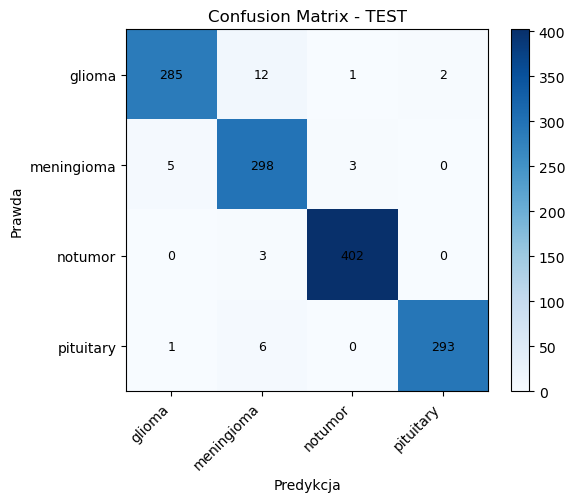

In [34]:
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(targs, preds)

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm, cmap="Blues")
ax.figure.colorbar(im, ax=ax)
ax.set_xticks(range(len(classes)))
ax.set_yticks(range(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha="right")
ax.set_yticklabels(classes)
ax.set_xlabel("Predykcja")
ax.set_ylabel("Prawda")
ax.set_title("Confusion Matrix - TEST")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=9)

plt.tight_layout()
plt.show()

In [37]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)


def denorm_img(x3hw):
    return (x3hw * IMAGENET_STD + IMAGENET_MEAN).clamp(0,1)

def gradcam_resnet18(model, x1_3hw, target_class=None, layer=None):
    model.eval()
    if layer is None:
        layer = model.layer4
    
    feats = None
    grads = None
    
    def f_hook(m, i, o):
        nonlocal feats
        feats = o
    def b_hook(m, gi, go):
        nonlocal grads
        grads = go[0]
        
    h1 = layer.register_forward_hook(f_hook)
    
    try:
        h2 = layer.register_full_backward_hook(b_hook)
    except:
        h2 = layer.register_backward_hook(b_hook)
    
    out = model(x1_3hw)
    probs = out.softmax(dim=1)
    pred_idx = int(probs.argmax(1))
    if target_class is None:
        target_class = pred_idx
    
    model.zero_grad()
    out[0, target_class].backward()
    
    weights = grads.mean(dim=(2,3), keepdim=True)
    cam = (weights * feats).sum(dim=1, keepdim=True)
    cam = F.relu(cam)
    cam = F.interpolate(cam, size=x1_3hw.shape[-2:], mode="bilinear", align_corners=False)
    cam = cam[0,0].detach().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() + 1e-6)
    
    h1.remove()
    h2.remove()
    
    return cam, pred_idx, float(probs[0, pred_idx])



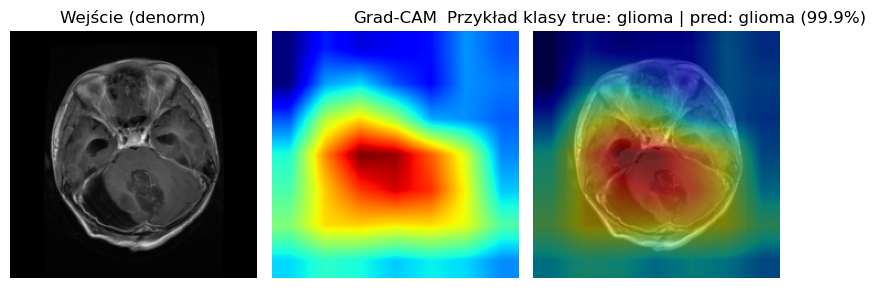

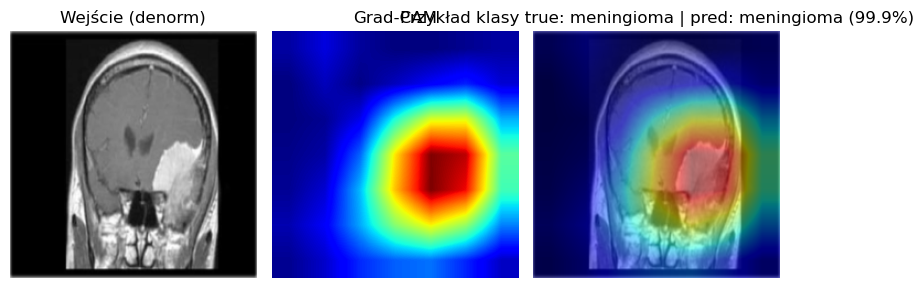

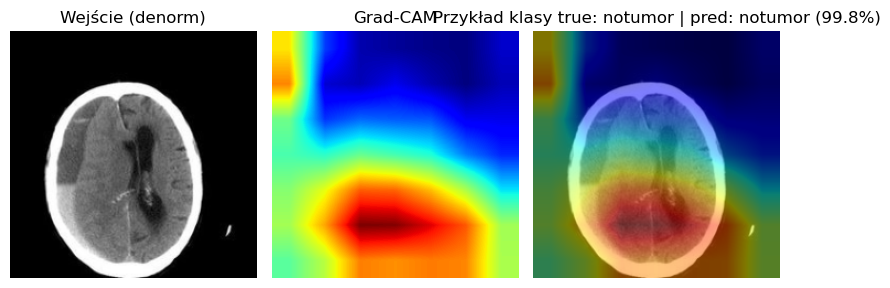

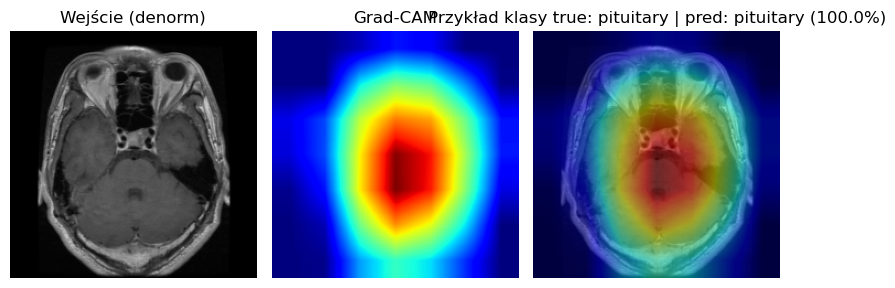

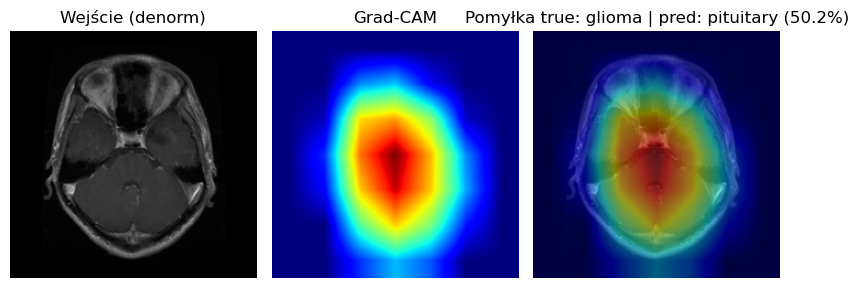

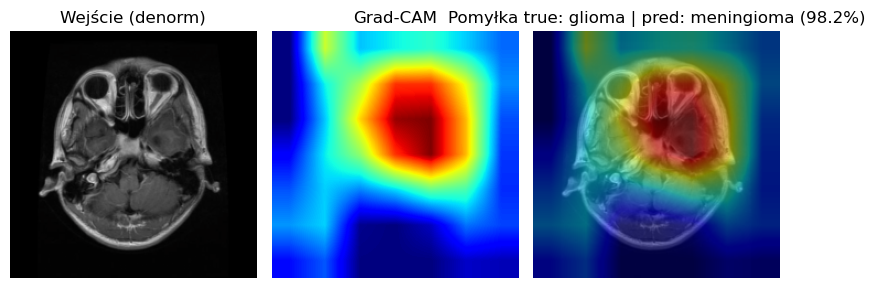

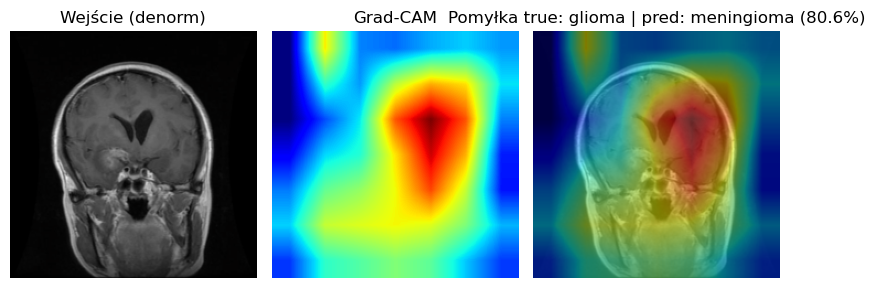

In [38]:
import random

try:
    mis_idx = np.where(preds != targs)[0].tolist()
except NameError:
    mis_idx = []
    
def show_cam_for_index(ds, idx, title_prefix=""):
    x3hw, y = ds[idx]
    x1 = x3hw.unsqueeze(0)
    cam, pred_idx, pred_prob = gradcam_resnet18(model, x1, target_class=None)
    
    img = denorm_img(x3hw).permute(1,2,0).numpy()
    
    overlay = 0.5*img + 0.5*plt.cm.jet(cam)[...,:3]
    
    true_name = classes[y]
    pred_name = classes[pred_idx]
    title = f"{title_prefix} true: {true_name} | pred: {pred_name} ({pred_prob:.1%})"
    
    plt.figure(figsize=(8,3))
    plt.subplot(1,3,1); plt.imshow(img); plt.axis("off"); plt.title("Wejście (denorm)")
    plt.subplot(1,3,2); plt.imshow(cam, cmap="jet"); plt.axis("off"); plt.title("Grad-CAM")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.axis("off"); plt.title(title)
    plt.tight_layout(); plt.show()

per_class_shown = set()
for i in range(len(test_ds)):
    _, y = test_ds[i]
    if y not in per_class_shown:
        show_cam_for_index(test_ds, i, title_prefix="Przykład klasy")
        per_class_shown.add(y)
    if len(per_class_shown) == len(classes):
        break

for i in mis_idx[:3]:
    show_cam_for_index(test_ds, i, title_prefix="Pomyłka")
            
    

In [39]:
import json, torch, torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

try:
    with open("classes.json") as f:
        classes = json.load(f)
except FileNotFoundError:
    from torchvision import datasets
    from pathlib import Path
    classes = datasets.ImageFolder(Path("data")/"train").classes

NUM_CLASSES = len(classes)

model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model.load_state_dict(torch.load("resnet18_finetuned_mri.pt", map_location="cpu"))
model.eval(); print("Model ready. Classes:", classes)


Model ready. Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [40]:
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

IMAGENET_MEAN=[0.485,0.456,0.406]
IMAGENET_STD =[0.229,0.224,0.225]

eval_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

IMAGENET_MEAN_T = torch.tensor(IMAGENET_MEAN).view(3,1,1)
IMAGENET_STD_T  = torch.tensor(IMAGENET_STD ).view(3,1,1)
def denorm(x3hw):
    return (x3hw*IMAGENET_STD_T + IMAGENET_MEAN_T).clamp(0,1)

@torch.no_grad()
def predict_image(path):
    pil = Image.open(path).convert("L")
    x = eval_tfms(pil).unsqueeze(0)    
    out = model(x)                            
    probs = out.softmax(1)[0].numpy()          
    pred_idx = int(probs.argmax())
    return pil, probs, pred_idx

def gradcam_resnet18(x1_3hw, target_class=None, layer=None):
    model.eval()
    if layer is None: layer = model.layer4
    feats, grads = None, None
    def f_hook(m, i, o): 
        nonlocal feats; feats = o
    def b_hook(m, gi, go): 
        nonlocal grads; grads = go[0]
    h1 = layer.register_forward_hook(f_hook)
    try: h2 = layer.register_full_backward_hook(b_hook)
    except: h2 = layer.register_backward_hook(b_hook)

    out = model(x1_3hw)                
    probs = out.softmax(1)
    pred_idx = int(probs.argmax(1))
    if target_class is None: target_class = pred_idx

    model.zero_grad(set_to_none=True)
    out[0, target_class].backward()

    weights = grads.mean(dim=(2,3), keepdim=True)   
    cam = (weights * feats).sum(dim=1, keepdim=True)
    cam = F.relu(cam)
    cam = F.interpolate(cam, size=x1_3hw.shape[-2:], mode="bilinear", align_corners=False)
    cam = cam[0,0].detach().cpu().numpy()
    cam = (cam - cam.min())/(cam.max() + 1e-6)
    h1.remove(); h2.remove()
    return cam, pred_idx, float(probs[0, pred_idx])

def show_prediction_with_cam(path):
    pil, probs, pred_idx = predict_image(path)
    x = eval_tfms(pil).unsqueeze(0)
    cam, pred_idx2, pred_prob = gradcam_resnet18(x, target_class=None)

    x_den = denorm(x[0]).permute(1,2,0).numpy()
    overlay = 0.5*x_den + 0.5*plt.cm.jet(cam)[...,:3]

    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1); plt.imshow(x_den); plt.axis("off"); plt.title("Obraz (denorm)")
    plt.subplot(1,3,2); plt.imshow(cam, cmap="jet"); plt.axis("off"); plt.title("Grad-CAM")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.axis("off")
    plt.title(f"pred: {classes[pred_idx2]}  ({pred_prob:.1%})")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,3))
    idxs = np.arange(len(classes))
    plt.bar(idxs, probs)
    plt.xticks(idxs, classes, rotation=45, ha="right")
    plt.ylabel("Prawdopodobieństwo")
    plt.title("Rozkład prawdopodobieństw")
    plt.tight_layout(); plt.show()


Przykładowy plik: data\test\glioma\Te-glTr_0000.jpg


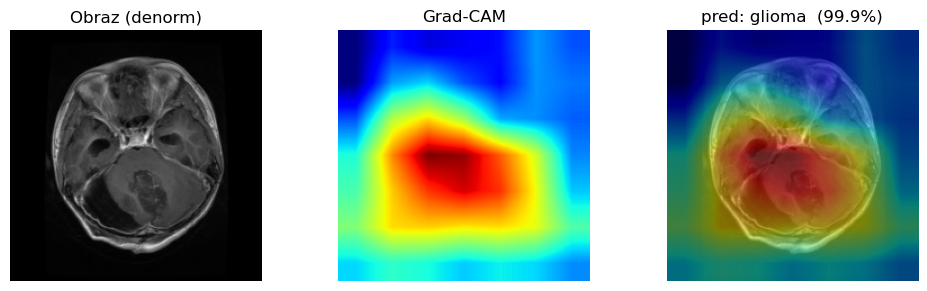

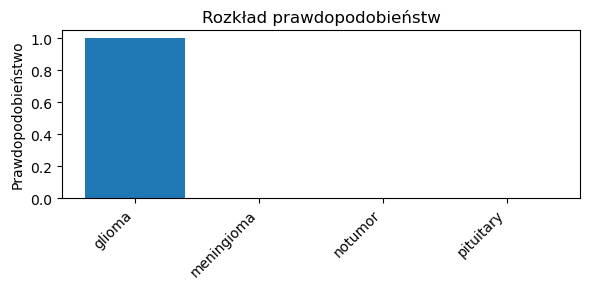

In [41]:
from pathlib import Path, PurePath
example_path = next((Path("data")/"test"/classes[0]).glob("*.jpg"))
print("Przykładowy plik:", example_path)

show_prediction_with_cam(example_path)
